<a href="https://colab.research.google.com/github/JunSeokCheon/eCommerce_weblog_analysis/blob/master/eCommerce_weblog_RFManalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - 이번 프로젝트는 kaggle에서 제공하는 데이터셋인 eCommerce 웹 로그 데이터 분석 프로젝트이다.
### 1. 데이터 전처리
### 2. 데이터 분석 & 시각화
### 3. 데이터 모델링

#### 해당 파일은 데이터 분석 & 시각화 과정이다.
#### 이 과정에서는 RFM 분석을 진행할 예정이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ecommerce_log_analysis

/content/drive/MyDrive/ecommerce_log_analysis


In [ ]:
ls

2019-Nov.csv
2019-Oct.csv
data_load.ipynb
ecommerce-behavior-data-from-multi-category-store.zip
eCommerce_weblog_analysis.ipynb
eCommerce_weblog_preprocessing.ipynb
eCommerce_weblog_RFManalysis.ipynb
kaggle.json
refined_2019_Oct.csv


## 데이터 load & import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import squarify
import datetime as dt

%matplotlib inline

In [ ]:
ecommerce_df = pd.read_csv("refined_2019_Oct.csv", index_col = 0, usecols=['kst_time','event_type','price','user_id','user_session'])

In [ ]:
ecommerce_df = ecommerce_df.reset_index()

In [ ]:
ecommerce_df.head()

,event_type,price,user_id,user_session,kst_time
0,view,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01 09:00:00
1,view,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01 09:00:01
2,view,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01 09:00:04
3,view,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,2019-10-01 09:00:05
4,view,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,2019-10-01 09:00:10


## RFM ?
RFM의 개념은 비교적 간단합니다. 아래 세가지 단어의 약자를 따서 RFM이라고 부르는데요.  
Recency : 얼마나 최근에 구매했는가  
Frequency : 얼마나 자주 구매했는가  
Monetary : 얼마나 많은 금액을 지출했는가  
즉, 사용자별로 얼마나 최근에, 얼마나 자주, 얼마나 많은 금액을 지출했는지에 따라 사용자들의 분포를 확인 하거나 사용자 그룹(또는 등급)을 나누어 분류 하는 분석 기법입니다. 

RFM 분석은 기본적으로 evnet_type이 purchase 유저기준으로 진행하기 때문에, 필터링 한다.  
같은 유저라도 세션이 다를 수 있으니, 세션별로 그룹핑을 진행한다.

In [ ]:
ecommerce_df = ecommerce_df[ecommerce_df['event_type'] == 'purchase']

In [ ]:
ecommerce_df['kst_time'] = pd.to_datetime(ecommerce_df['kst_time'])

In [ ]:
ecommerce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549507 entries, 111 to 26560567
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_type    549507 non-null  object        
 1   price         549507 non-null  float64       
 2   user_id       549507 non-null  int64         
 3   user_session  549507 non-null  object        
 4   kst_time      549507 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 25.2+ MB


In [ ]:
ecommerce_df = ecommerce_df.groupby(by="user_session").agg(Date_order=("kst_time", lambda x: x.max()), / 
                                                           user_id=("user_id", lambda x: x.unique()), / 
                                                           session_count=("user_session", "count"),  /
                                                           money_spent=("price", "sum")).reset_index(drop=True)

In [ ]:
ecommerce_df

,Date_order,user_id,session_count,money_spent
0,2019-10-06 20:34:30,546521725,1,289.52
1,2019-10-25 17:39:11,560486342,1,171.90
2,2019-10-17 22:37:59,560744406,2,379.78
3,2019-10-15 17:09:02,520649833,1,90.07
4,2019-10-23 23:27:08,534210306,2,571.92
...,...,...,...,...
466794,2019-10-29 14:18:45,565273783,2,2715.20
466795,2019-10-04 18:01:28,548691169,1,193.03
466796,2019-10-14 18:19:57,560049739,1,131.64
466797,2019-10-10 21:34:49,517051774,1,130.12


## RFM 분석
RFM 분석의 3가지 속성인 Recency, Frequency, Monetary를 구할 것이다.

In [ ]:
ecommerce_df['Date_order'].max()

Timestamp('2019-11-01 08:59:16')

데이터 마지막날짜에서 현재 구입 날짜를 빼면 마지막 구매 날짜가 나오는데, 일자 데이터 타입으로 변경해서 넣는다.

In [ ]:
last_day = dt.datetime(2019,11,2)
ecommerce_df['last_purchase'] = last_day - ecommerce_df['Date_order']
ecommerce_df['last_purchase'].astype('timedelta64[D]')
ecommerce_df['last_purchase']=ecommerce_df['last_purchase'] / np.timedelta64(1, 'D')
ecommerce_df.head()

,Date_order,user_id,session_count,money_spent,last_purchase
0,2019-10-06 20:34:30,546521725,1,289.52,26.142708
1,2019-10-25 17:39:11,560486342,1,171.90,7.264456
2,2019-10-17 22:37:59,560744406,2,379.78,15.056956
3,2019-10-15 17:09:02,520649833,1,90.07,17.285394
4,2019-10-23 23:27:08,534210306,2,571.92,9.022824


user_id로 그룹핑해서 Recency, Frequency, Monetary 구한다.  
Recency - last_purchase 중 최소 일자(min())  
Frequency - user_id의 개수를 세면 해당 일자로부터의 빈도(count)  
Monetary - 그룹핑된 데이터에서 money_spend의 합(sum))

In [ ]:
RFM = ecommerce_df.groupby('user_id').agg(Recency=('last_purchase', lambda x: x.min()),  / 
                                          Frequency=('user_id', lambda x: x.count()),  / 
                                          Monetary=('money_spent', lambda x : x.sum()))

In [ ]:
RFM.head()

,Recency,Frequency,Monetary
user_id,,,
303160429,19.065637,1,340.59
340041246,18.009965,1,339.70
384989212,14.152789,1,41.44
401021311,11.444977,1,231.64
403013066,13.822766,1,807.16


### Recency 
얼마나 최근에 구입했는가 - 최소 6시간부터 마지막 날(11/1)에 구입한 유저까지 존재한다.

In [ ]:
RFM['Recency'].describe()

count    263445.000000
mean         14.852063
std           8.712395
min           0.625509
25%           7.297870
50%          14.316053
75%          21.912280
max          31.618449
Name: Recency, dtype: float64

### Frequency  
얼마나 자주 구입했는가 - 최소 1번 구입부터 152번이나 구입한 유저까지 존재한다.

In [ ]:
RFM['Frequency'].describe()

count    263445.000000
mean          1.771903
std           2.399952
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         152.000000
Name: Frequency, dtype: float64

### Monetary  
얼마나 많은 금액을 지출했는가 - 최소 0.88달러에서 최대 265569달러 제품까지 구입한 유저가 존재한다.

In [ ]:
RFM['Monetary'].describe()

count    263445.000000
mean        773.853133
std        2291.897206
min           0.880000
25%         145.430000
50%         287.970000
75%         738.740000
max      265569.520000
Name: Monetary, dtype: float64

위의 과정에서 RFM은 구했으나 RFM 분석에서 더 중요한건 RFM 세분화(Segmentation)이다


## RFM Segmentation
RFM 세분화는 데이터에 따라 사용자의 그룹을 식별하는 방법입니다.  
이를 통해, 특정 고객 그룹을 타켓팅할 수 있어서 응답률이 향상되고 서비스 충성도가 높아집니다.  
RFM 모델에서 고객 세분화를 하는 가장 간단한 방법으로 사분위수를 사용할 것 입니다.  
우리는 1에서 4까지 점수를 RFM에 할당할 것이고, RFM Score는 각 점수를 합하여 계산합니다.


고객 세분화를 위한 사분위수 기준 정하기 위해 quantile 함수 사용합니다.

In [ ]:
RFM.quantile(q=[0.25, 0.5, 0.75])

,Recency,Frequency,Monetary
0.25,7.297870,1.0,145.43
0.50,14.316053,1.0,287.97
0.75,21.912280,2.0,738.74


In [ ]:
quartiles = RFM.quantile(q=[0.25, 0.5, 0.75]).to_dict()
quartiles

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 145.43, 0.5: 287.97, 0.75: 738.74},
 'Recency': {0.25: 7.2978703703703705,
  0.5: 14.316053240740741,
  0.75: 21.912280092592592}}

### RFM 세분화 함수
recency가 작으면 작을 수록 충성도가 높은 고객  
monetary, frequency가 클수록 충성도가 높은 고객  
RFM score = recency.quartiles + monetary.quartiles + frequency는.quartiles  
score가 작을수록 충성도가 높은 고객으로 설정한다.

In [ ]:
def for_recency(x, parm, data):
  if x <= data[parm][0.25]:
    return 1
  elif x <= data[parm][0.50]:
    return 2
  elif x <= data[parm][0.75]:
    return 3
  else:
    return 4
  
def for_monfre(x, parm, data):
  if x <= data[parm][0.25]:
    return 4
  elif x <= data[parm][0.50]:
    return 3
  elif x <= data[parm][0.75]:
    return 2
  else:
    return 1

In [ ]:
RFM['R_quartile'] = RFM['Recency'].apply(for_recency, args=('Recency', quartiles))
RFM['F_quartile'] = RFM['Frequency'].apply(for_monfre, args=('Frequency', quartiles))
RFM['M_quartile'] = RFM['Monetary'].apply(for_monfre, args=('Monetary', quartiles))
RFM['RFM_Score'] = RFM.R_quartile.map(int) + RFM.F_quartile.map(int) + RFM.M_quartile.map(int)
RFM.head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
user_id,,,,,,,
303160429,19.065637,1,340.59,3,4,2,9
340041246,18.009965,1,339.70,3,4,2,9
384989212,14.152789,1,41.44,2,4,4,10
401021311,11.444977,1,231.64,2,4,3,9
403013066,13.822766,1,807.16,2,4,1,7


In [ ]:
RFM['RFM_Score'].unique()

array([ 9, 10,  7,  8, 11, 12,  5,  6,  4,  3])

RFM Score에 따른 고객 분류를 정의한다.  
3 - Leading Customer  
4, 5, 6 - Loyal Customers  
7, 8, 9 - Promising Customers  
10, 11 - Hibernating Customers  
12 - Loss Customers

In [ ]:
def RFM_Define(data):
  if data['RFM_Score'] >= 12:
    return 'Loss Customers'
  elif ((data['RFM_Score'] >= 10) and (data['RFM_Score'] < 12)):
    return 'Hibernating Customers'
  elif ((data['RFM_Score'] >= 7) and (data['RFM_Score'] < 10)):
    return 'Promising Customers'
  elif ((data['RFM_Score'] >= 4) and (data['RFM_Score'] < 7)):
    return 'Loyal Customers'
  else:
    return 'Leading Customer'

In [ ]:
RFM['RFM_Label'] = RFM.apply(RFM_Define, axis = 1)
RFM.head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Label
user_id,,,,,,,,
303160429,19.065637,1,340.59,3,4,2,9,Promising Customers
340041246,18.009965,1,339.70,3,4,2,9,Promising Customers
384989212,14.152789,1,41.44,2,4,4,10,Hibernating Customers
401021311,11.444977,1,231.64,2,4,3,9,Promising Customers
403013066,13.822766,1,807.16,2,4,1,7,Promising Customers


각 RFM_Label 별로 분포를 살펴보겠습니다.

In [ ]:
RFM_desc = RFM.groupby('RFM_Label').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count'],
}).round(1)
RFM_desc

Recency Frequency Monetary        
                         mean      mean     mean   count
RFM_Label                                               
Hibernating Customers    20.2       1.0    199.3   75547
Leading Customer          3.6       7.3   4534.7   12285
Loss Customers           26.8       1.0     84.3   17901
Loyal Customers          10.2       3.0   1529.7   51408
Promising Customers      12.6       1.2    498.2  106304

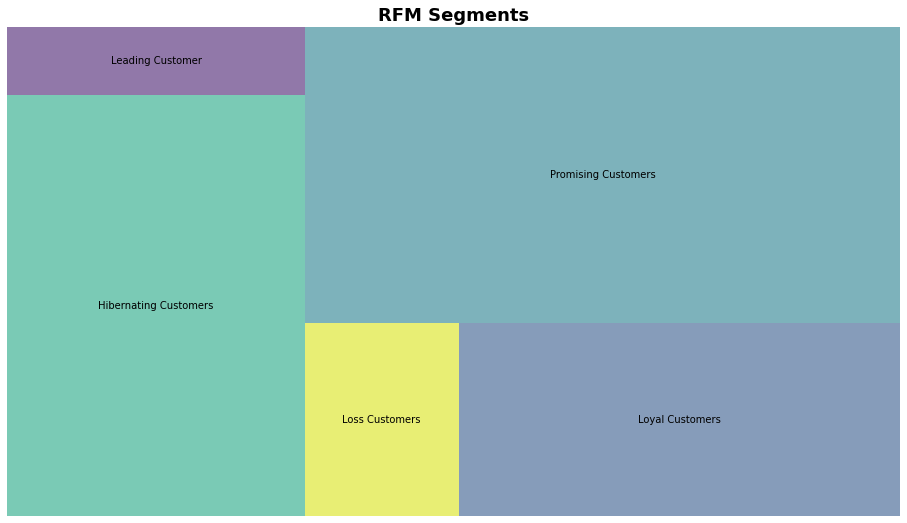

In [ ]:
RFM_desc.columns = RFM_desc.columns.droplevel()
RFM_desc.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=RFM_desc['Count'], 
              label=['Hibernating Customers',
                     'Leading Customer',
                     'Loss Customers',
                     'Loyal Customers',
                     'Promising Customers'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

RFM Segment에 따른 고객 마케팅 전략을 생각해보자  
Leading Customer - 해당 고객군에게 보상을 한다. 그러면 신제품의 얼리 어답터가 될 수도 있고, 해당 서비스를 홍보할 것이다.  
Loyal Customers - 더 높은 가치의 제품을 상향 판매하고, 리뷰 요청을 진행한다.  
Promising Customers - 멤버십/서비스 충성 프로그램을 제공하고, 맞춤 추천을 제공한다.  
Hibernating Customers - 이메일 개인화와 특정 제품에 대한 특정 할인으로 관심을 되살린다.  
Loss Customers - 목표 캠페인을 진행하여 관심을 유도하되 많은 리소스를 쏟지 않는다.